## Analyzing on the 1.1 mas inner circle
Here we look at the 1.1 mas inner circle which encloses the clusters COIN-Gaia_13 (moving group), Platais_10 (not in crossmatch table), UBC_13 (moving group), UBC_14 (not in hunt catalogue), UBC_21 (not in hunt catalogue), UPK_495 (not in hunt catalogue), UPK_533 (not in hunt catalogue), UPK_654 (not in hunt catalogue).
We analyze various asterometric paramaters like dispersion.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const


cantat = pd.read_csv('Data\\CantatGaudin\\cantatgaudinfile.csv')
cantat = cantat.assign(r50_dist = (np.tan(cantat['r50']*np.pi/180) * cantat['dmode']))
cantat = cantat.assign(inner = np.where(cantat['Plx'] > 1.1, 1, 0))

hunt = pd.read_csv('Data\\Hunt\\huntfile.csv')
xmatch = pd.read_csv('Data\\Hunt\\xmatchfile.csv').dropna(subset='Sep')
khar = pd.read_csv('Data\\Kharchenko\\kharchenkofile.csv').query('Type != "g"')
dias = pd.read_csv('Data\\Dias\\diasfile.csv')
dias['Cluster'] = dias['Cluster'].str.replace(' ', '_').str.replace('-', '_')

def datahandler(df_lit, df=hunt, crossmatch=xmatch):

    if df_lit is cantat: # Define the source catalog and the column name of the cluster name, each table has different names for the cluster name column
        sourcecat = 'Cantat-Gaudin+20'
        NameCol = 'Cluster'
    elif df_lit is khar:
        sourcecat = 'Kharchenko+13'
        NameCol = 'Name'
    elif df_lit is dias:
        sourcecat = 'Dias+02'
        NameCol = 'Cluster'

    df = df.query('Type == "o"') #Only open clusters
    crossmatch = crossmatch.query('SourceCat == @sourcecat') #Crossmatch with the source catalog of the named catalogue
    crossmatch = crossmatch #Drop duplicates

    hunt_xm = pd.merge(crossmatch, df, on='ID', how='inner') #Crossmatched clusters
    hunt_xm.drop_duplicates(subset = ['ID'], keep='first', inplace=True)

    allnames = hunt_xm.assign(synonym = hunt_xm['AllNames'].str.split(',')).explode('synonym') #Create AllNames column with synonyms of the OCs
    allnames = allnames.add_suffix('_hunt') #Add suffix to the columns to avoid confusion with the other table

    df_matched = pd.merge(allnames, df_lit, left_on='synonym_hunt', right_on=NameCol, how='outer', indicator=True) #Merge the crossmatched table with the named catalogue
    
    superclusters = df_matched.groupby(['ID_hunt', 'Name_hunt'])[NameCol].agg(list).reset_index() # multiple lit clusters link to one hunt cluster
    subclusters = df_matched.groupby([NameCol])[['ID_hunt', 'Name_hunt']].agg(list).reset_index() # multiple hunt clusters link to one lit cluster

    matched = df_matched.query('_merge == "both"') #Matched clusters
    not_matched = df_matched.query('_merge == "left_only"') #Not matched clusters

    hunt_matched = matched.filter(regex='_h$').drop(columns=['synonym_h']) # Matched clusters in Hunt (I)
    # remove _h from the column names
    hunt_matched.columns = hunt_matched.columns.str.replace('_h', '')

    lit_matched = matched[df_lit.columns] # Matched clusters in literature (II)
    lit_not_matched = not_matched[df_lit.columns] # Not matched clusters in literature (III)

    print(f'Matched {len(hunt_matched)} + Not matched {len(lit_not_matched)} = Total {len(df_lit)}')
    return hunt_matched, lit_matched, lit_not_matched, superclusters, subclusters

cantat_matched, cantat_lit, cantat_not_matched = datahandler(cantat)
khar_matched, khar_lit, khar_not_matched = datahandler(khar)

Matched 1460 + Not matched 4047 = Total 1481


ValueError: too many values to unpack (expected 3)

In [ ]:
def galto_galcen(data):
    x, y, z = data['X'].values, data['Y'].values, data['Z'].values
    coords = coord.SkyCoord(x=x*u.pc, y=y*u.pc, z=z*u.pc, frame='galactic').transform_to(coord.Galactocentric)
    return coords.x.value, coords.y.value, coords.z.value

def galcen_to_gal(data):
    x, y, z = data['X'].values, data['Y'].values, data['Z'].values
    coords = coord.SkyCoord(x=x*u.pc, y=y*u.pc, z=z*u.pc, representation_type='cartesian', frame='galactocentric')
    coords = coords.transform_to(coord.Galactic).cartesian
    return coords

def radec_to_gal(data):
    ra, dec, dist = data['RAhour'].values, data['DEdeg'].values, data['d'].values
    coords = coord.SkyCoord(ra=ra*u.hourangle, dec=dec*u.deg, distance=dist*u.pc).transform_to(coord.Galactic).cartesian
    return coords

def parallax_to_dist(plx):
    return 1000/plx


In [ ]:
# plot cantat_not_matched clusters with a parallax larger than 3 on the x y plane using the columns 'X' and 'Y'
# plt.scatter(cantat_not_matched['X'], cantat_not_matched['Y'], c='r')

# plt.axis('equal')

# plt.xlim(-2000, 2000)
# plt.ylim(-2000, 2000)

# # for the clusters with inner == 1, put a circle around them and a little arrow pointing to them with their name, dont use a loop
# inner = cantat_not_matched.query('inner == 1')
# plt.scatter(inner['X'], inner['Y'], edgecolors='b', facecolor='None', s=250, label='Plx > 1.1')

# # add xy labels and plot labels and legend
# plt.xlabel('X [pc]')
# plt.ylabel('Y [pc]')

# # Make circle with radius of 500 pc around the 0,0
# circle = plt.Circle((0, 0), parallax_to_dist(1.1), color='black', fill=False, ls='-.', label=f'{round(parallax_to_dist(1.1))} pc')
# plt.gca().add_artist(circle)

# plt.legend()
# plt.show()

cantat_not_matched.query('inner == 1')

,Cluster,RAdeg,DEdeg,GLON,GLAT,r50,N,pmRA,s_pmRA,e_pmRA,...,dmode84,dmode95,dmode+01,dmode-01,X,Y,Z,Rgc,r50_dist,inner
226,COIN-Gaia_13,83.186,42.087,167.459,4.776,1.003,165.0,-3.828,0.185,0.017,...,512.2,512.9,486.4,538.8,-497.4,110.6,42.6,8838.0,8.951554,1.0
1072,Platais_10,205.220,-59.271,309.220,2.996,0.485,21.0,-30.591,0.475,0.102,...,239.3,239.6,233.3,244.7,150.8,-184.8,12.5,8191.3,2.021454,1.0
1309,UBC_13,120.914,3.540,218.116,17.666,1.100,36.0,-7.749,0.158,0.032,...,612.7,614.2,575.4,650.3,-457.7,-359.1,185.3,8805.0,11.724119,1.0
1310,UBC_14,294.746,3.703,41.734,-8.829,1.068,46.0,0.131,0.210,0.024,...,751.8,753.6,696.8,809.6,552.3,492.7,-115.0,7803.3,13.963064,1.0
1315,UBC_21,130.455,-20.747,244.679,12.944,1.083,47.0,-6.500,0.224,0.033,...,875.0,877.4,801.7,954.8,-363.3,-767.8,195.2,8737.1,16.474982,1.0
1446,UPK_495,105.787,-40.885,251.411,-15.314,1.068,48.0,-2.489,0.160,0.023,...,673.0,674.1,629.1,719.7,-206.4,-613.7,-177.3,8568.4,12.516424,1.0
1455,UPK_533,122.887,-52.521,267.426,-10.160,1.181,58.0,-6.876,0.299,0.043,...,345.6,345.9,333.6,357.5,-15.3,-339.4,-60.9,8362.1,7.114326,1.0
1494,UPK_654,277.320,-34.528,359.531,-10.817,0.326,62.0,1.206,0.241,0.025,...,502.7,503.9,477.0,527.3,492.0,-4.0,-94.0,7848.0,2.850038,1.0


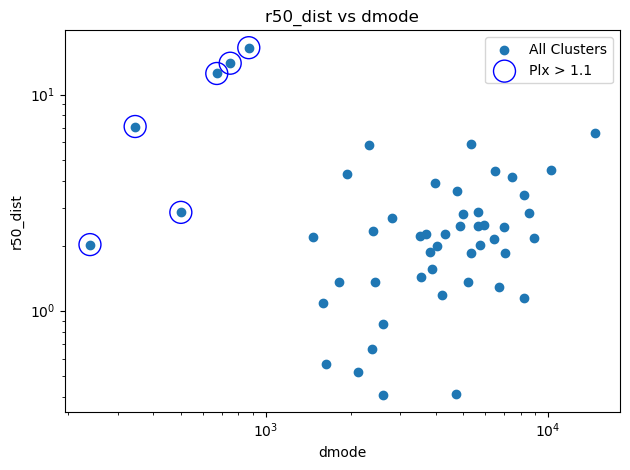

In [ ]:
# Plot r50_dist as a function of dmode
plt.scatter(cantat_not_matched['dmode'], cantat_not_matched['r50_dist'], label='All Clusters')
plt.scatter(inner['dmode'], inner['r50_dist'], edgecolors='b', facecolor='None', s=250, label='Plx > 1.1')

# Add labels and title
plt.xlabel('dmode')
plt.ylabel('r50_dist')
plt.title('r50_dist vs dmode')

plt.xscale('log')
plt.yscale('log')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


,Name,ID,AllNames,Type,CST,N,CSTt,Nt,RAdeg,DEdeg,...,diffAV50,diffAV84,MOD16,MOD50,MOD84,minClSize,isMerged,isGMMMemb,NXmatches,XmatchType
0,1636-283,0,"1636-283,C1636-283,ESO_452-11,MWSC_2436",o,8.106141,38,8.794951,32,249.855743,-28.399194,...,1.471477,1.946265,13.771433,14.001991,14.187698,20,0,0,2,1:m
1,ADS_16795,1,"ADS_16795,AR_Cas",o,6.832199,41,6.832199,41,352.592165,58.553413,...,0.470770,0.693890,6.491674,6.649982,6.814627,40,0,0,1,1:1
2,AH03_J0748+26.9,2,"AH03_J0748+26.9,AH03_J0748-26.9,AH03_J0748_26....",o,11.585524,68,11.781309,66,117.155887,-26.972679,...,1.079003,1.455453,13.326923,13.521471,13.707494,10,0,0,2,1:m
3,ASCC_5,3,"ASCC_5,MWSC_93",o,8.316422,25,8.316422,25,14.469082,55.829174,...,0.723468,1.067812,11.046813,11.212086,11.370137,10,0,0,1,1:1
4,ASCC_6,4,"ASCC_6,MWSC_141,Theia_2326",o,19.258570,209,19.258570,209,26.842159,57.738607,...,0.757964,1.104530,10.703223,10.890650,11.055896,80,0,0,2,1:m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7162,vdBergh_85,7162,vdBergh_85,o,11.847597,105,11.847597,105,101.720134,1.324256,...,2.159117,2.505461,10.931759,11.125109,11.264691,80,0,0,1,1:1
7163,vdBergh_92,7163,vdBergh_92,o,21.995554,345,21.995554,345,106.036502,-11.442338,...,2.381747,2.710961,10.040602,10.191625,10.338547,40,0,0,1,m:1
7164,vdBergh_113,7164,"UBC_1005,UFMG_84,vdBergh_113",o,15.770199,163,15.829355,152,272.165492,-21.441478,...,2.649548,2.985685,10.599004,10.748435,10.885481,80,0,0,3,1:m
7165,vdBergh_130,7165,vdBergh_130,o,11.430369,162,12.842494,131,304.517447,39.366647,...,2.574298,2.929418,10.996379,11.143586,11.296269,80,0,0,1,1:1
